# Building an ARIMA model for time series forecasting of river flow data


In [1]:
# import data and view as plot
from arima_functions import *
import pandas as pd
import matplotlib.pyplot as plt

# import data - using data from the Brahamaputra River, Bangladesh
file_path = "DATA/2651100_Q_Day.Cmd.txt"
metadata, data = read_data(file_path)
station_info, parsed_data = process_data(metadata, data)

print("Station Information:")
print(station_info)
print("Data:")
print(parsed_data.head())


Station Information:
{'GRDC-No.': '2651100', 'River': 'BRAHMAPUTRA RIVER', 'Station': 'BAHADURABAD', 'Country': 'BD', 'Latitude (DD)': '25.18', 'Longitude (DD)': '89.67', 'Catchment area (km²)': None, 'Altitude (m ASL)': '19.0', 'Time series': '1985-04 - 1992-03', 'No. of years': '8', 'Last update': '2018-05-29'}
Data:
         Date   Value
0  1985-04-03  6370.0
1  1985-04-04  6320.0
2  1985-04-05  6290.0
3  1985-04-06  6350.0
4  1985-04-07  6920.0


<Figure size 1000x600 with 0 Axes>

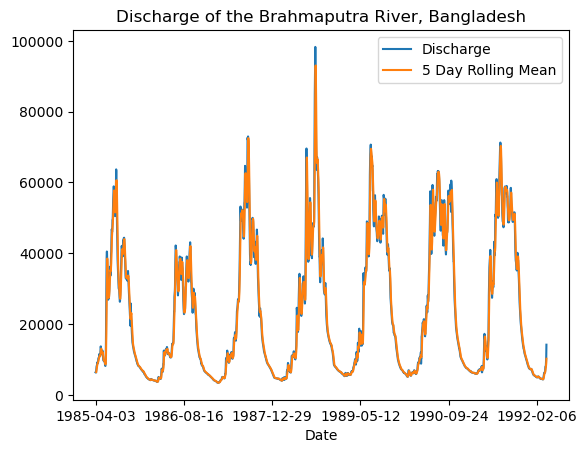

In [2]:
# plot the data
plt.figure(figsize=(10,6))
parsed_data.plot(y='Value', x='Date', title='Discharge of the Brahmaputra River, Bangladesh')
# add rolling mean value    
parsed_data['Value'].rolling(window=5).mean().plot()
parsed_data['Avg'] = parsed_data['Value'].rolling(window=5).mean()
plt.legend(['Discharge', '5 Day Rolling Mean'])
plt.show()

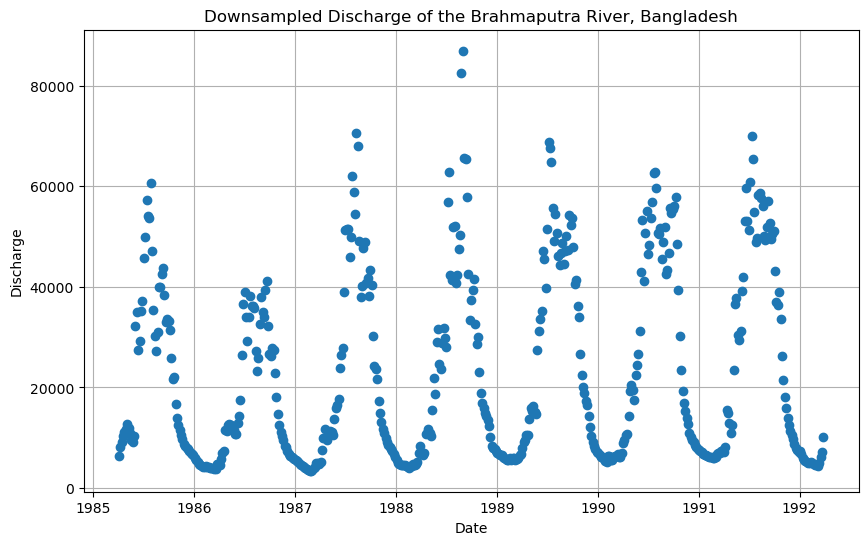

In [3]:
# downsample to 5 day intervals
parsed_data = downsample(parsed_data)

# Plot the downsampled data
plt.figure(figsize=(10, 6))
plt.plot(parsed_data['Sampled'], marker='o', linestyle='-')
plt.title('Downsampled Discharge of the Brahmaputra River, Bangladesh')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.grid(True)
plt.show()


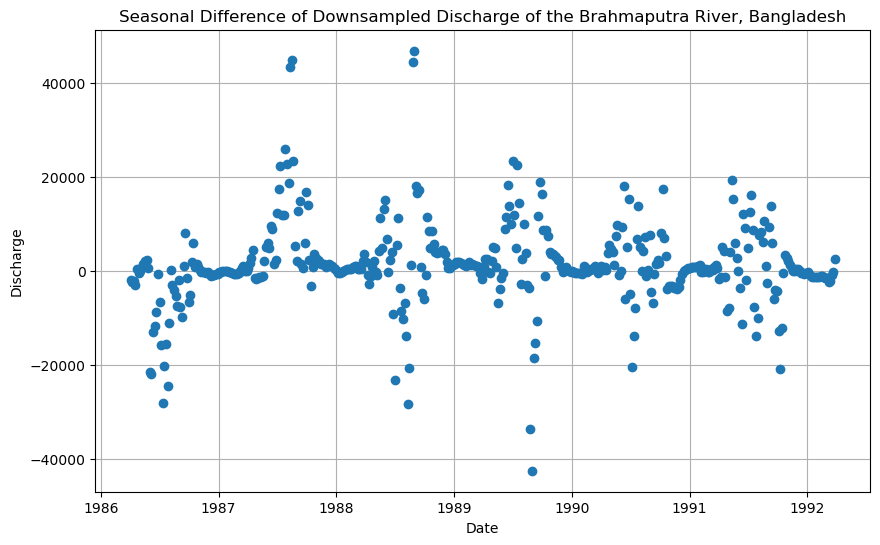

In [4]:
# as data will be seasonal, do seasonal differencing
parsed_data['Seasonal Difference'] = (parsed_data['Sampled'] - parsed_data['Sampled'].shift(365))
plt.figure(figsize=(10, 6))
plt.plot(parsed_data['Seasonal Difference'], marker='o', linestyle='-')
plt.title('Seasonal Difference of Downsampled Discharge of the Brahmaputra River, Bangladesh')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.grid(True)
plt.show()


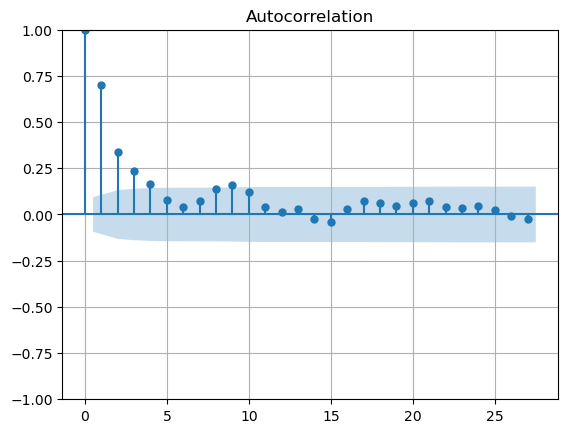

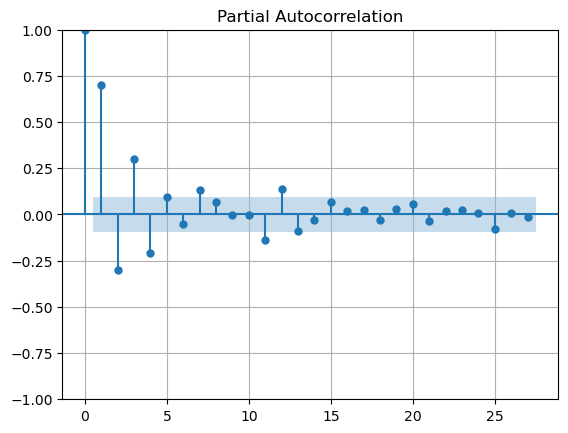

In [5]:
# calculate the ACF and PACF to determine order of ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(parsed_data['Seasonal Difference'].dropna())
grid = plt.grid(True)
plot_pacf(parsed_data['Seasonal Difference'].dropna())
grid = plt.grid(True)


Roughly reading from these plots:
- Predict around 1-2 auto-regressive terms
- 0 non-seasonal differences
- 2 lagged forecast errors

and for the seasonal component:
- 0 auto-regressive terms
- 1 seasonal difference
- 0 lagged forecast errors
with a seasonal period of 73 (365/5 due to down-sampling)

In [6]:
# split the data into training and testing sets
train, test = split_data(parsed_data, split=0.8)

# fit the ARIMA model
model = arima_model(train, order=(2,0,2), seasonal_order=(0,1,0,73))

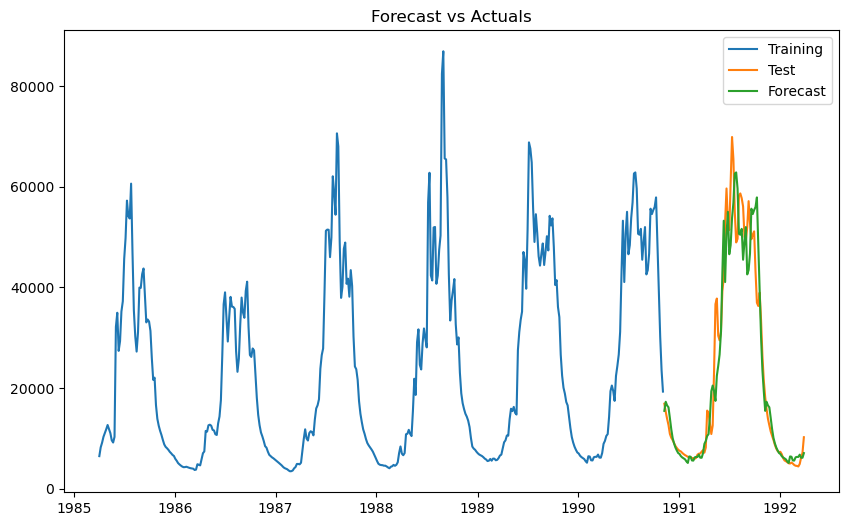

In [7]:
# predict the future using the model and plot the results
forecast_data = forecast(model, test)
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()



In [8]:
# # find best model - switch to python to run this cell   
# import itertools

# # Define parameters for ARIMA orders
# p = range(0,5)  # AutoRegressive (AR) order
# d = [0]  # Integrated (I) order data is already stationary and downsampled
# q = range(0, 3)  # Moving Average (MA) order

# # Define seasonal parameters for ARIMA seasonal orders
# P = [0]  # Seasonal AutoRegressive (SAR) order
# D = range(0,2)  # Seasonal Integrated (SI) order 
# Q = [0]  # Seasonal Moving Average (SMA) order
# s = [73]  # Seasonal period 

# # Generate all possible combinations of parameters
# orders = list(itertools.product(p, d, q))
# seasonal_orders = list(itertools.product(P, D, Q, s))

# best_aic = float('inf')
# best_model = None

# # Iterate over all combinations of parameters and fit the models
# for order in orders:
#     for seasonal_order in seasonal_orders:
#         try:
#             model = ARIMA(train.dropna(), order=order, seasonal_order=seasonal_order)
#             model_fit = model.fit()

#             # Check if the current model has a lower AIC value than the best model found so far
#             if model_fit.aic < best_aic:
#                 best_aic = model_fit.aic
#                 best_model = model_fit
#                 best_order = order
#                 best_seasonal_order = seasonal_order

#         except:
#             continue

# # Print the summary of the best model
# print("Best Model:")
# print(best_model.summary())
# print("Best AIC:", best_aic)
# print("Best ARIMA Order:", best_order)
# print("Best Seasonal Order:", best_seasonal_order)

# # store the model
# # best_model.save('bramaputra_best_model.pkl')

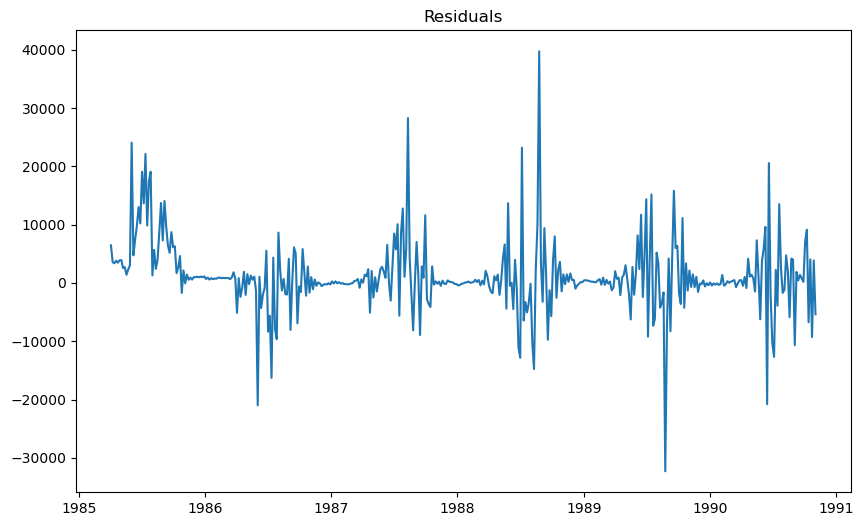

Mean Squared Error: 35769479.21307413
Root Mean Squared Error: 5980.75908335005
Mean Absolute Percentage Error: 16.10340400896359


In [9]:
# evaluate the model
mse, rmse, mape = evaluate_model(model, test, plot=True)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)



This model order generalises fairly well to the other river flow data sets, so it can be used for a range of river flow estimates - confirmed with 2 rivers in Bangladesh.

# Assess the model for world river flows

Using river data from more rivers to see the generalisability of the model.

Training the same model on each river, and then using the model to forecast the river flow for the next year. Evaluating the RMSE and MAPE of the forecasted river flow against the actual river flow.


In [10]:
rivers = {'Brahmaputra, BD': 'DATA/2651100_Q_Day.Cmd.txt',
            'Tista, BD': 'DATA/2651080_Q_Day.Cmd.txt', 
            'Tadi Khola, NP': 'DATA/2549220_Q_Day.Cmd.txt',
            'Chepe Khola, NP': 'DATA/2549230_Q_Day.Cmd.txt',
            'Ganges, BD': 'DATA/2646200_Q_Day.Cmd.txt',
            'Chindwin, MM': 'DATA/2260100_Q_Day.Cmd.txt',}
            # 'Irrawaddy, MM': 'DATA/2260400_Q_Day.Cmd.txt',
            # 'Sittang, MM': 'DATA/2261500_Q_Day.Cmd.txt',}


results = {}

for river, file_path in rivers.items():
    metadata, data = read_data(file_path)
    station_info, parsed_data = process_data(metadata, data)
    parsed_data = downsample(parsed_data)
    train, test = split_data(parsed_data, split=0.8)
    model = arima_model(train, order=(3,0,2), seasonal_order=(0,1,0,73))
    try:
        mse, rmse, mape = evaluate_model(model, test, plot=False)
    except ValueError:
        mse, rmse, mape = None, None, None
    results[river] = {'RMSE': rmse, 'MAPE': mape}

print(results)


{'Brahmaputra, BD': {'RMSE': 5970.8059256452625, 'MAPE': 15.711477395108203}, 'Tista, BD': {'RMSE': 629.1316441200262, 'MAPE': 58.722421253538435}, 'Tadi Khola, NP': {'RMSE': 30.438337650096315, 'MAPE': 49.07155019468022}, 'Chepe Khola, NP': {'RMSE': 15.276885813646851, 'MAPE': nan}, 'Ganges, BD': {'RMSE': 8518.853924037274, 'MAPE': 51.95372558115562}, 'Chindwin, MM': {'RMSE': 1867.8464790291368, 'MAPE': nan}, 'Irrawaddy, MM': {'RMSE': 2551.401427834043, 'MAPE': 38.306035510833276}, 'Sittang, MM': {'RMSE': 241.8329495984703, 'MAPE': nan}}


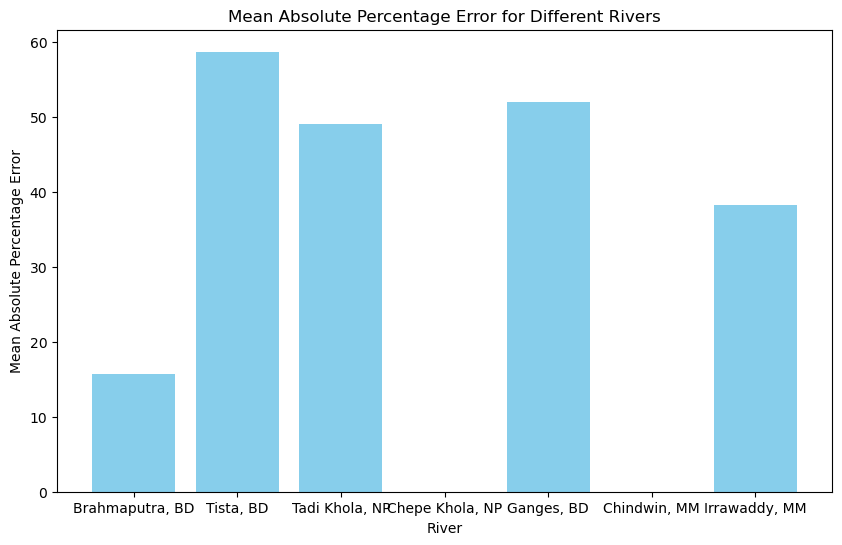

In [11]:
# plot only the MAPE
mape = [results[river]['MAPE'] for river in results.keys()]
plt.figure(figsize=(10,6))
plt.bar(results.keys(), mape, color='skyblue')
plt.title('Mean Absolute Percentage Error for Different Rivers')
plt.xlabel('River')
plt.ylabel('Mean Absolute Percentage Error')
plt.show()

In [12]:
# print metadata
print(metadata)


{'Title': 'GRDC STATION DATA FILE', 'Format': 'DOS-ASCII', 'Field delimiter': ';', 'file generation date': '2024-03-01', 'GRDC-No.': '2261500', 'River': 'SITTANG RIVER', 'Station': 'TOUNGOO', 'Country': 'MM', 'Latitude (DD)': '18.92', 'Longitude (DD)': '96.47', 'Catchment area (km²)': '14660.0', 'Altitude (m ASL)': '50.0', 'Next downstream station': '-', 'Remarks': '', 'Owner of original data': 'Myanmar - Department of Meteorology and Hydrology', 'Data Set Content': 'MEAN DAILY DISCHARGE (Q)', 'Unit of measure': 'm³/s', 'Time series': '1978-01 - 2023-12', 'No. of years': '47', 'Last update': '2024-02-15', 'Table Header': '', 'hh': 'mm      - Time', 'Data lines': '16801'}


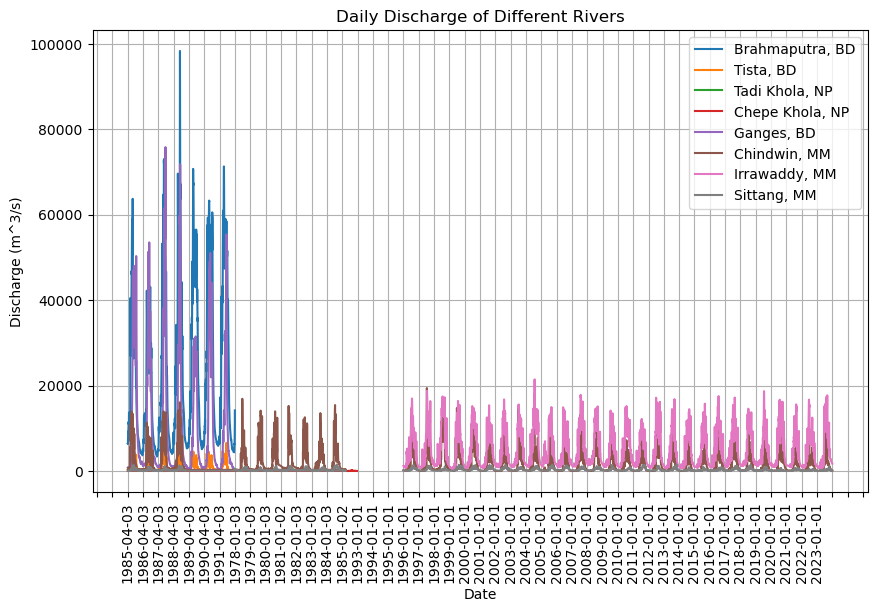

In [13]:
# plot the raw data for the rivers on one plot
import matplotlib.dates as mdates
plt.figure(figsize=(10,6))
for river, file_path in rivers.items():
    metadata, data = read_data(file_path)
    station_info, parsed_data = process_data(metadata, data)
    # parsed_data = downsample(parsed_data)
    # plot time series against date for each river
    plt.plot(parsed_data['Date'], parsed_data['Value'], label=river)
    
plt.title('Daily Discharge of Different Rivers')
plt.ylabel('Discharge (m^3/s)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

# Set xticks to only show once a year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)

plt.show()

Using the lat and lon provided for each on the rivers, attempt to scale the discharge to get an estimate of velocity.


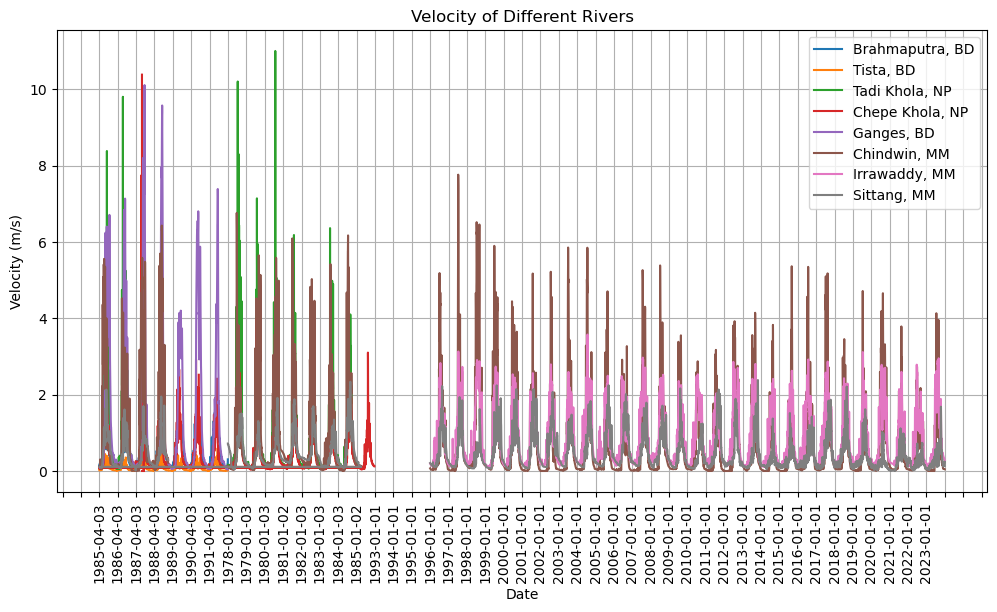

In [14]:
width_estimates = [9310, 2200, 50, 50, 1500, 500, 1200, 130] # in meters
depth_estimates = [5, 5, 2, 2, 5, 5, 5, 5] # in meters assuming 2,5,10 meters for small, medium, large rivers

plt.figure(figsize=(12,6))
i = 0
for river, file_path in rivers.items():
    metadata, data = read_data(file_path)
    station_info, parsed_data = process_data(metadata, data)
    # parsed_data = downsample(parsed_data)
    # plot time series against date for each river
    parsed_data['Width'] = width_estimates[i]
    parsed_data['Depth'] = depth_estimates[i]
    parsed_data['Velocity'] = parsed_data['Value'] / (parsed_data['Width'] * parsed_data['Depth'])

    plt.plot(parsed_data['Date'], parsed_data['Velocity'], label=river)
    i += 1

plt.title('Velocity of Different Rivers')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

# Set xticks to only show once a year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)

plt.show()

With this rough estimate of velocity (using google maps to get the river width at each station coordinates) I can plot the estimated river velocity timeseries for each river.

Now I can attempt to fit the arrima model to the river velocity data, and see if the model generalises to river velocity data, and if it can predict the river velocity for the next year.

Estimated Depth: 4.966187620527828


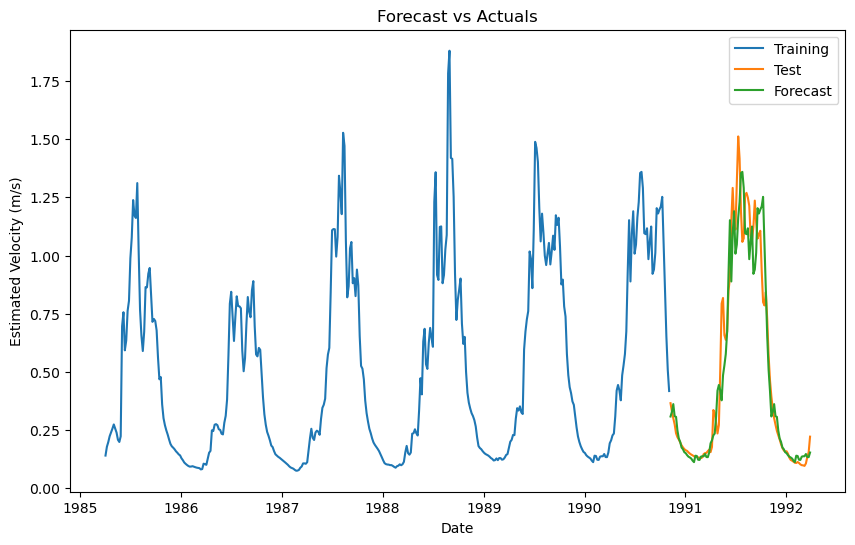

Mean Squared Error: 0.016678074528186992
Root Mean Squared Error: 0.12914361977344058
Mean Absolute Percentage Error: 15.716574328053525


In [22]:
# using the velocity data for the Brahmaputra River, Bangladesh
metadata, data = read_data('DATA/2651100_Q_Day.Cmd.txt')
station_info, parsed_data = process_data(metadata, data)

# depth estimates using the paper
# Q = W^1.02 * D^1.74 * S^0.35
Q = parsed_data['Value'].mean() # average discharge m^3/s
W = 9310 # width in meters
S = 2.82 / 1000 # average slope m/m 

D = (Q / (W**1.02 * S**0.35))**(1/1.74) # depth in meters

width = 9310
depth = D

print("Estimated Depth:", D)

parsed_data['Velocity'] = parsed_data['Value'] / (width * depth)
parsed_data = downsample(parsed_data)

# split the data into training and testing sets
train, test = split_data(parsed_data, split=0.8)

# fit the ARIMA model
model = arima_model(train, order=(3,0,2), seasonal_order=(0,1,0,73))

# predict the future using the model and plot the results
forecast_data = forecast(model, test)
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
plt.title('Forecast vs Actuals')
plt.ylabel('Estimated Velocity (m/s)')
plt.xlabel('Date')
plt.legend()
plt.show()

# evaluate the model
mse, rmse, mape = evaluate_model(model, test, plot=False)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)

Estimated Depth: 8.384024996765582


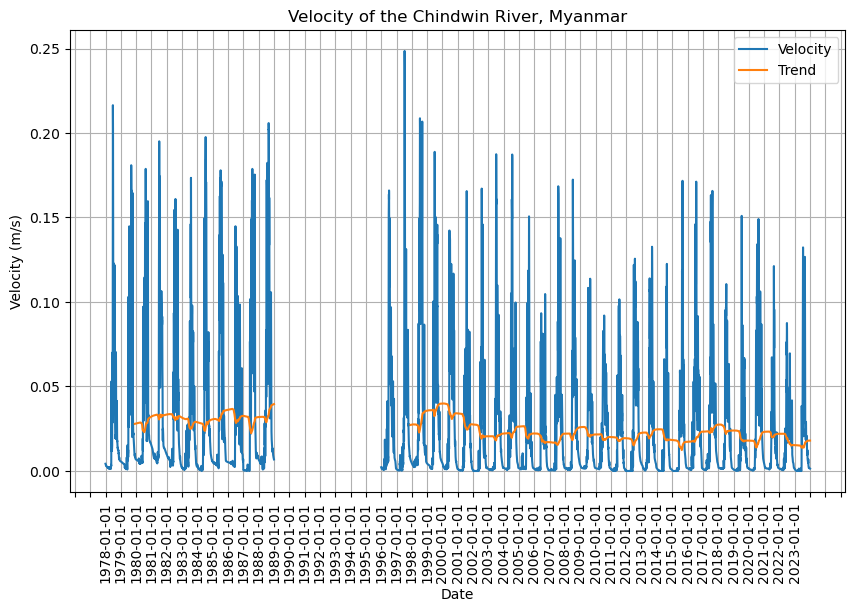

In [23]:
# long term trends in the data
# looking at the Myanmar rivers as they have the longest data
metadata, data = read_data('DATA/2260100_Q_Day.Cmd.txt')
station_info, parsed_data = process_data(metadata, data)

# depth estimates using the paper
# Q = W^1.02 * D^1.74 * S^0.35
Q = parsed_data['Value'].mean() # average discharge m^3/s
W = 500 # width in meters
S = 0.89 / 1000 # average slope m/m from Wikipedia

D = (Q / (W**1.02 * S**0.35))**(1/1.74) # depth in meters

width = 9310
depth = D

print("Estimated Depth:", D)
depth = D
parsed_data['Velocity'] = parsed_data['Value'] / (width * depth)

# plot the data and an trend line
plt.figure(figsize=(10,6))
plt.plot(parsed_data['Date'], parsed_data['Velocity'], label='Velocity')
plt.plot(parsed_data['Date'], parsed_data['Velocity'].rolling(window=700).mean(), label='Trend')
plt.title('Velocity of the Chindwin River, Myanmar')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

# Set xticks to only show once a year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=90)

plt.show()